In [2]:
%load_ext autoreload
%autoreload 2


https://debuggercafe.com/basic-introduction-to-class-activation-maps-in-deep-learning-using-pytorch/

In [3]:
# !pip install grad-cam
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [4]:
# Weights & Biases
import wandb
from pytorch_lightning.loggers import WandbLogger

# Pytorch modules
import torch

# Pytorch-Lightning
from pytorch_lightning import Trainer
import argparse
from lib.train.admin.environment import env_settings
import os
import numpy as np
import random
import importlib
import cv2 as cv
from lib.train.base_functions import *

from lib.utils.box_ops import giou_loss
from torch.nn.functional import l1_loss
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
# train pipeline related
from lib.train.base_functions import *

# forward propagation related
import importlib
# from sklearn.model_selection import KFold
from lib.train.admin import multigpu
from pytorch_lightning.callbacks import ModelCheckpoint
from lib.pylight import LitEXOTActor, LitEXOTMergeActor, LitEXOTSTActor, RobotDataModule, LitSTARKActor, LitSTARKSTActor
from pl_prac import Settings, init_seeds, parse_args_jup

from typing import OrderedDict
from pytorch_lightning import LightningModule
from lib.models.exot import build_exotst_odin, build_exotst_cls


In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [6]:
args = ["--script", "exot_st2", '--config', 'cos_mix_lowdim', '--save_dir', '.', '--mode', 'single', 
'--script_prv', 'exot_st2', '--config_prv', 'cos_mix_lowdim', '--st1_name', 
"cos_mix_lowdim_fold_0_5/cos_mix_lowdim_fold_0_5/EXOTST_epoch=250-v1/EXOTST_epoch=71.pth.tar"]
args = parse_args_jup(args)
cv.setNumThreads(0)
torch.backends.cudnn.benchmark = args.cudnn_benchmark

print('script_name: {}.py  config_name: {}.yaml'.format(args.script, args.config))

'''2021.1.5 set seed for different process'''
if args.seed is not None:
    if args.local_rank != -1:
        init_seeds(args.seed + args.local_rank)
    else:
        init_seeds(args.seed)

settings = Settings()
cfg = settings.set_args(args)
cfg.TRAIN.BATCH_SIZE = 1
# update settings based on cfg
if settings.local_rank in [-1, 0]:
    print("New configuration is shown below.")
    for key in cfg.keys():
        print("%s configuration:" % key, cfg[key])
        print('\n')  
update_settings(settings, cfg)

if settings.script_name == "exot_st2" or  settings.script_name == "exot_merge":
    objective = {'giou': giou_loss, 'l1': l1_loss, 'cls': BCEWithLogitsLoss(), 'objcls': CrossEntropyLoss()}  #reduction='none'
    loss_weight = {'giou': cfg.TRAIN.GIOU_WEIGHT, 'l1': cfg.TRAIN.L1_WEIGHT, 'cls': cfg.TRAIN.CLS_WEIGHT, 'objcls': cfg.TRAIN.OBJCLS_WEIGHT}
elif settings.script_name == "exot_st1":
    objective = {'giou': giou_loss, 'l1': l1_loss}  #reduction='none'
    loss_weight = {'giou': cfg.TRAIN.GIOU_WEIGHT, 'l1': cfg.TRAIN.L1_WEIGHT}
elif settings.script_name == "stark_s" or settings.script_name == "stark_st1":
    objective = {'giou': giou_loss, 'l1': l1_loss}
    loss_weight = {'giou': cfg.TRAIN.GIOU_WEIGHT, 'l1': cfg.TRAIN.L1_WEIGHT}        
elif settings.script_name == "stark_st2":
    objective = {'giou': giou_loss, 'cls': BCEWithLogitsLoss()}
    loss_weight = {'giou': cfg.TRAIN.GIOU_WEIGHT, 'cls': 1.0}

script_name: exot_st2.py  config_name: cos_mix_lowdim.yaml
New configuration is shown below.
MODEL configuration: {'HEAD_TYPE': 'CORNER', 'CLS_HEAD': True, 'NLAYER_HEAD': 3, 'HEAD_ABS': 'backbone', 'ODIN_TYPE': 'cos', 'HIDDEN_DIM': 256, 'NUM_OBJECT_QUERIES': 1, 'POSITION_EMBEDDING': 'sine', 'PREDICT_MASK': False, 'LOSS_TYPE': 'None', 'BACKBONE': {'TYPE': 'resnet50', 'OUTPUT_LAYERS': ['layer3'], 'STRIDE': 16, 'DILATION': False}, 'TRANSFORMER': {'NHEADS': 8, 'DROPOUT': 0.1, 'DIM_FEEDFORWARD': 2048, 'ENC_LAYERS': 6, 'DEC_LAYERS': 6, 'PRE_NORM': False, 'DIVIDE_NORM': False}}


TRAIN configuration: {'TRAIN_CLS': True, 'LR': 0.0001, 'WEIGHT_DECAY': 0.0001, 'EPOCH': 100, 'LR_DROP_EPOCH': 90, 'BATCH_SIZE': 1, 'NUM_WORKER': 8, 'OPTIMIZER': 'ADAMW', 'BACKBONE_MULTIPLIER': 0.1, 'REID_WEIGHT': 3.0, 'EXIT_WEIGHT': 3.0, 'GIOU_WEIGHT': 2.0, 'L1_WEIGHT': 5.0, 'CLS_WEIGHT': 1.0, 'OBJCLS_WEIGHT': 0.2, 'DEEP_SUPERVISION': False, 'FREEZE_BACKBONE_BN': True, 'FREEZE_LAYERS': ['conv1', 'layer1'], 'PRINT_INT

In [7]:
if cfg.MODEL.ODIN_TYPE == 'cls':
    net = build_exotst_cls(cfg)
else:
    net = build_exotst_odin(cfg)

net = net.module if multigpu.is_multi_gpu(net) else net
        
checkpoint = torch.load(f"checkpoints/train/{args.script_prv}/{args.st1_name}")

try:
    missing_k, unexpected_k = net.load_state_dict(checkpoint["net"], strict=False)
except:
    ckptitem = checkpoint['net'].items()
    net_kv = OrderedDict()
    count = 0
    for key, value in ckptitem:
        if 'objcls' in key:
            continue
        # name = key.replace('objcls_head', 'objcls')
        net_kv[key] = value
    missing_k, unexpected_k = net.load_state_dict(net_kv, strict=False)
# net.eval() ?? 
# missing_k, unexpected_k = net.load_state_dict(net_kv, strict=False)

print("previous checkpoint is loaded.")
print("missing keys: ", missing_k)
print("unexpected keys:", unexpected_k)

net.eval()

head channel: 256
previous checkpoint is loaded.
missing keys:  []
unexpected keys: []


EXOTST1(
  (backbone): Joiner(
    (0): Backbone(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): FrozenBatchNorm2d()
            )
 

In [8]:
k=0
nums_folds = 5
robot_data = RobotDataModule(data_dir='data/robot-data/', k=k, num_splits=nums_folds, batch_size=cfg.TRAIN.BATCH_SIZE, kfoldness = True, test_size=0.4)
robot_data.fill_state(cfg, settings)
robot_data.prepare_data()
robot_data.setup(stage='fit')

In [9]:
from lib.utils.misc import NestedTensor
from lib.utils.box_ops import box_cxcywh_to_xyxy, box_xywh_to_xyxy
from lib.utils.merge import merge_template_search
count = 0
# cam = GradCAM(model=model, target_layers=target_layers,
#                 #use_cuda=args.use_cuda
#                 )
for data in robot_data.val_dataloader(): 
    data = data
    break

In [10]:
import numpy as np
import cv2
import argparse
from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk

In [25]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def show_cam(CAMs, width, height, orig_image, class_idx, all_classes, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.applyColorMap(cv2.resize(cam,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + orig_image * 0.5
        # put class label text on the result
        cv2.putText(result, all_classes[class_idx[i]], (20, 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        #cv2.imshow('CAM', result/255.)
        #cv2.waitKey(0)
        plt.imshow(result/255.)
        #cv2.imwrite(f"outputs/CAM_{save_name}.jpg", result)

In [12]:
feat_dict_list = []
# process the templates
for i in range(2):
    template_img_i = data['template_images'][i].view(-1, *data['template_images'].shape[2:])  # (batch, 3, 128, 128)
    template_att_i = data['template_att'][i].view(-1, *data['template_att'].shape[2:])  # (batch, 128, 128)
    feat_dict_list.append(net.forward_backbone(NestedTensor(template_img_i, template_att_i)))

# process the search regions (t-th frame)
search_img = data['search_images'].view(-1, *data['search_images'].shape[2:])  # (batch, 3, 320, 320)
search_att = data['search_att'].view(-1, *data['search_att'].shape[2:])  # (batch, 320, 320)
feat_dict_list.append(net.forward_backbone(NestedTensor(search_img, search_att)))

# run the transformer and compute losses
seq_dict = merge_template_search(feat_dict_list, return_search=True, return_template=True)

template_bboxes = box_xywh_to_xyxy(data['template_anno'])  #(N_t, batch, 4)
template_joint = None
annot = (template_bboxes, template_joint) 

In [13]:
#seq_dict.keys()
seq_dict['feat'].shape
#seq_dict['mask'].shape
#seq_dict['pos'].shape
#seq_dict['feat_z'].shape

torch.Size([528, 1, 256])

In [14]:
output_embed, enc_mem = net.transformer(seq_dict["feat"], seq_dict["mask"], net.query_embed.weight,
                                            seq_dict["pos"], return_encoder_output=True)

In [15]:
features_blobs = []
def hook_feature(module, input, output):
    print(output.shape)
    features_blobs.append(output.data.cpu().numpy())

def hook_feature2(module, input, output):
    print(output)
    features_blobs.append(output.data.cpu().numpy())

#target_layers = [model.net.odin_cls.h, model.net.cls_head.layers[2]]
net.backbone[0].register_forward_hook(hook_feature)
net.odin_cls.reduceNet.register_forward_hook(hook_feature)
#model.net.odin_cls.h.register_forward_hook(hook_feature)
#model.net.cls_head.layers[2].register_forward_hook(hook_feature)
#model._modules.get('layer4').register_forward_hook(hook_feature)
# get the softmax weight
params = list(net.parameters())
weight_softmax = torch.matmul(torch.matmul(params[-6], params[-8]), params[-10]).data.numpy()
#weight_softmax = np.squeeze(params[-6].data.numpy())

In [16]:
batch_feat = seq_dict['feat_x'].permute((1, 0, 2)) 
print(batch_feat.shape)

torch.Size([1, 400, 256])


In [14]:
batch_feat = enc_mem[-net.feat_len_s:].transpose(0, 1) 
print(batch_feat.shape)

torch.Size([1, 400, 256])


In [ ]:
enc_opt = enc_mem[-net.feat_len_s:].transpose(0, 1)
dec_opt = output_embed.squeeze(0).transpose(1, 2)  # (B, C, N)
att = torch.matmul(enc_opt, dec_opt)  # (B, HW, N)
opt = (enc_opt.unsqueeze(-1) * att.unsqueeze(-2)) #.permute((0, 3, 2, 1)).contiguous()  # (B, HW, C, N) --> (B, N, C, HW)
# print("opt shape", opt.shape)
batch_feat = torch.nn.functional.normalize(torch.squeeze(opt, -1), p=1.0)


In [32]:
print(params[-7].shape, params[-8].shape, params[-9].shape, params[-10].shape)

torch.Size([256]) torch.Size([256, 256]) torch.Size([256]) torch.Size([256, 512]) torch.Size([512]) torch.Size([512]) torch.Size([512, 512, 3, 3]) torch.Size([512])


In [16]:
weight_softmax.shape

(53, 512)

In [17]:
out_dict = {}
if batch_feat.dim() <2:
    batch_feat = torch.unsqueeze(batch_feat, 0)

batch_feat = batch_feat.permute(0,2,1)
if net.cls_type == 'cls':
    tmp_obj = net.obj_cls(batch_feat)
    out_dict.update({'pred_logits': net.cls_head(output_embed)[-1], 'pred_obj': tmp_obj })
else:
    tmp_obj, h, g = net.odin_cls(batch_feat)

    out_dict.update({'pred_logits': net.cls_head(output_embed)[-1], 'pred_obj': tmp_obj, 'pred_h':h, 'pred_g':g})


torch.Size([1, 512, 10, 10])


In [18]:
out_dict.keys()

dict_keys(['pred_logits', 'pred_obj', 'pred_h', 'pred_g'])

In [19]:
out_dict_box, outputs_coord, flagFeat = net.forward_box_head(output_embed, enc_mem, annot = annot)
# merge results
out_dict.update(out_dict_box)

In [20]:
# get the softmax probabilities
probs = F.softmax(out_dict['pred_obj']).data.squeeze()
# get the class indices of top k probabilities
class_idx = topk(probs, 1)[1].int()

/home/ella/miniconda/envs/deformable_detr/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [20]:
class_idx

tensor([5], dtype=torch.int32)

In [29]:
orig_image = torch.squeeze(data['search_images']).permute(1,2,0)
width, height = data['search_images'].shape[3], data['search_images'].shape[4]
all_classes = []
for i in range(34+19):
    all_classes.append(str(i+1))


In [36]:
orig_image -= torch.min(orig_image)
orig_image /= torch.max(orig_image)
print(orig_image)

tensor([[[0.2773, 0.2585, 0.3591],
         [0.2773, 0.2585, 0.3591],
         [0.2773, 0.2585, 0.3591],
         ...,
         [0.2080, 0.2171, 0.3473],
         [0.2138, 0.2230, 0.3532],
         [0.2138, 0.2230, 0.3532]],

        [[0.2773, 0.2585, 0.3591],
         [0.2773, 0.2585, 0.3591],
         [0.2773, 0.2585, 0.3591],
         ...,
         [0.2080, 0.2171, 0.3473],
         [0.2138, 0.2230, 0.3532],
         [0.2138, 0.2230, 0.3532]],

        [[0.2773, 0.2585, 0.3591],
         [0.2773, 0.2585, 0.3591],
         [0.2773, 0.2585, 0.3591],
         ...,
         [0.2080, 0.2171, 0.3473],
         [0.2138, 0.2230, 0.3532],
         [0.2138, 0.2230, 0.3532]],

        ...,

        [[0.4391, 0.3648, 0.4061],
         [0.4391, 0.3648, 0.4061],
         [0.4391, 0.3648, 0.4061],
         ...,
         [0.0000, 0.0340, 0.2003],
         [0.0000, 0.0340, 0.2003],
         [0.0000, 0.0340, 0.2003]],

        [[0.4391, 0.3648, 0.4061],
         [0.4391, 0.3648, 0.4061],
         [0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


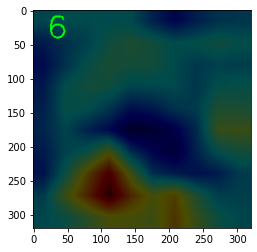

In [26]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)
# file name to save the resulting CAM image with
save_name = "test.jpg"
# show and save the results
show_cam(CAMs, width, height, orig_image, class_idx, all_classes, save_name)

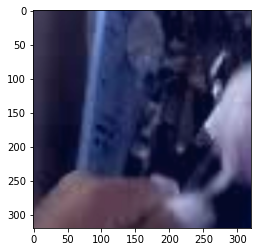

In [37]:
plt.imshow(orig_image)

In [39]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

target_layers = [net.odin_cls.reduceNet[-1]]
input_tensor = data['search_images']
# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(19+34)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(orig_image, grayscale_cam, use_rgb=True)

AssertionError: 

In [ ]:
  

# Construct the CAM object once, and then re-use it on many images:

#print(data.keys())
#odict_keys(['template_images', 'template_anno', 'template_masks', 'search_images', 
# 'search_anno', 'search_masks', 'search_exit', 'dataset', 'test_class', 'template_att', 'search_att', 'valid', 'label'])

#print(torch.argmax(data['label']))
#targets = None #[ClassifierOutputTarget(torch.argmax(data['label']))]
# input_tensor = robot_data[0]
gt = data['test_class']
print(gt)
target_categories = gt.cpu().data.numpy()
print(target_categories)
targets = [ClassifierOutputTarget(
            category) for category in target_categories]
grayscale_cam = cam(input_tensor=data, targets=targets)


# In this example grayscale_cam has only one image in the batch:
cam_images = []
for i in range(1):
    grayscale_cam_fr = grayscale_cam[0, :,:,i]
    visualization = show_cam_on_image(data['search_images'].permute(1,2,0).numpy(), grayscale_cam_fr, use_rgb=True)
    cam_images.append(visualization)
    

#cam_images = [show_cam_on_image(img, grayscale, use_rgb=True) for img, grayscale in zip(rgb_img, grayscale_cam)]
#visualization = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)

In [ ]:
plt.figure(figsize=(16,8))
n=1
for i in range(len(cam_images)):
    #print(i)
    vis_ = cam_images[i]
    raw_ = raw_img[i].permute(1,2,0)
    ax = plt.subplot(2,opt.n_frame,n) 
    ax.imshow(raw_)
    ax.axis('off')
    ax = plt.subplot(2,opt.n_frame,n+1)
    ax.imshow(vis_)
    ax.axis('off')
    n+=2
plt.tight_layout() 
plt.show()